In [ ]:
import numpy as np
from CoolProp.CoolProp import PropsSI

# Datos experimentales
t_exp = np.arange(0, 21, 1) * 60  # en segundos
T_exp = np.array([52, 81.5, 87.1, 90, 91.4, 91.1, 73.9, 81.7, 82.4, 82.5, 82.3, 82.3, 82.8, 74.4, 80.9, 83.1, 84.3, 84.7, 84.6, 83.9, 77.1])
M_exp = np.array([7.3, 7.74, 7.08, 6.24, 5.46, 4.64, 8.32, 7.78, 7.38, 7.04, 6.62, 6.18, 5.68, 8.86, 8.46, 8.08, 7.54, 6.9, 6.32, 5.82, 9.28])

### Euler con f de entalpía

In [5]:
# System parameters
F_max = 0.067666667  # Maximum inlet flow (kg/s)
V_base = 0.009759592 # Nominal vapor flow (kg/s)
S = 0.011714928
M_max = 8            # Maximum mass in evaporator (kg)
M_min = 5            # Minimum mass in evaporator (kg)


c_j = 4.2            # Heat capacity of the solution (kJ/kg·K)
#-------------------------------------------------------------------
# Entry data 
P1=57242.13          # Pressure inside the effect (Pa)
P=74000              # Atmospheric pressure inside the effect (Pa)
Ps=109663.79         # Pressure inside the effect (Pa)
x_f = 0.0287         # Salt mass fraction in F
x_L = 0.0557         # Salt mass fraction in L
T_f =17+273.15       # Temperature of the feed (K)

# Initial conditions
M = 7.3
M_salt = M * x_f
T = 273.15 + 52      # Initial temperature in the evaporator (K)
total_time = 20 * 60                    # 20 minutes
#-------------------------------------------------------------------
# Mathematic operations

#For the steam
H_liq = PropsSI('H', 'P', Ps, 'Q', 0, 'Water')
H_vap = PropsSI('H', 'P', Ps, 'Q', 1, 'Water')
l_heat = H_vap - H_liq                              # Latent heat of water vapor at Ps (J/kg)
Q = S * (l_heat /1000)                              # Added heat (kJ/s)


# Boiling point elevation (BPE) and T1 calculation
Tw = PropsSI('T', 'P', P1, 'Q', 0, 'Water') - 273.15
A = 8.325E-2 + (1.883E-4 * Tw) + (4.02E-6 * (Tw**2))
B = -7.625e-4 + (9.02e-5 * Tw) - (5.2e-7 * (Tw**2))
C = 1.522E-4 - (3E-6 * Tw) - (3E-8 * (Tw**2))
BPE = A * x_f + (B * (x_f**2)) + (C * (x_f**3))
T_eb = (Tw + BPE) + 273.15                           # Boiling point of the solution at P1 (K)
#------------------------------------------------------------------------

# Enthalpy functions
def h_liquid(T):
    hL=PropsSI('H', 'T', T, 'Q', 0, 'Water')/1000  # Produced vapor at P1, T1 without solute
    return hL  # Liquid enthalpy
def h_vapor(P1):
    Hv = PropsSI('H', 'P', P1, 'Q', 1, 'Water')/1000  # Produced vapor at P1, T1 without solute
    return Hv  # Liquid enthalpy
def h_liquidf(T,P):
    hF= PropsSI('H', 'T', T, 'P', P, 'Water')/1000  # Feed enthalpy at T and P
    return hF  # Liquid enthalpy

#------------------------------------------------------------------------
# Simulation settings
dt = 5                                  # time step (s)
steps = int(total_time / dt)
F = F_max                               # The simulation starts at F=Fmax to fill the evaporator

# Storage lists
time_list = []
M_list = []
M_salt_list = []
T_list = []
F_list = []
V_list = []
concentration_list = []
#------------------------------------------------------------------
# Euler loop with hysteresis
for step in range(steps):
    t = step * dt

    if M >= M_max:                        # If M < M_max close the valve so F = 0
        F = 0
    elif M <= M_min:                      # If M <= M_min open the valve so F = F_max
        F = F_max

    V = V_base if T >= T_eb else 0        # Conditions for the vapor flow

    h_f_in = h_liquidf(T_f,P)
    h_i = h_liquid(T)
    h_v = h_vapor(P1)
    #  Differential equations
    dM_dt = F - V
    dM_salt_dt = F * x_f
    dT_dt = ((F * (h_f_in - h_i)) - (V * (h_v - h_i)) + Q ) / (M * c_j)

    # Euler integration

    M += dM_dt * dt
    M_salt += dM_salt_dt * dt
    T += dT_dt * dt
    target_salt_mass=x_L*M
    # Save data
    time_list.append(t)
    M_list.append(M)
    M_salt_list.append(M_salt)
    T_list.append(T - 273.15)                               # Convert to °C
    F_list.append(F)
    V_list.append(V)
    concentration = (M_salt / M) * 100 if M > 0 else 0      # Convert to %
    concentration_list.append(concentration)


#### Plots

In [6]:
# Convertir tiempos experimentales a minutos
t_exp_min = t_exp / 60
Vexp=[0,0.54,1.2,2.04,2.82,3.64,4.02,4.56,4.96,5.3,5.72,6.16,6.66,6.92,7.32,7.7,8.24,8.88,9.46,9.96,10.24]
# Datos predichos desde tu diccionario de resultados
time_array = np.array(time_list) / 60  # en minutos
T_array = np.array(T_list)
M_array = np.array(M_list)

# Encontrar coincidencias exactas de tiempo
mask = np.isin(time_array, t_exp_min)

# Extraer datos predichos en esos tiempos
T_pred_match = T_array[mask]
M_pred_match = M_array[mask]
time_matched = time_array[mask]

# Crear diccionarios para acceder rápido por tiempo
T_pred_dict = dict(zip(time_matched, T_pred_match))
M_pred_dict = dict(zip(time_matched, M_pred_match))

# Obtener los valores predichos y experimentales en orden coincidente
T_pred = np.array([T_pred_dict[t] for t in t_exp_min if t in T_pred_dict])
M_pred = np.array([M_pred_dict[t] for t in t_exp_min if t in M_pred_dict])
T_exp_filtered = np.array([T_exp[i] for i, t in enumerate(t_exp_min) if t in T_pred_dict])
M_exp_filtered = np.array([M_exp[i] for i, t in enumerate(t_exp_min) if t in M_pred_dict])

# Función de error relativo cuadrático medio
def relative_rmse(y_real, y_pred):
    return np.sqrt(np.mean(((y_real - y_pred) / y_real) ** 2))

# Calcular errores
error_T = relative_rmse(T_exp_filtered, T_pred)
error_M = relative_rmse(M_exp_filtered, M_pred)

# Mostrar resultados
print(f"Error relativo cuadrático medio (Temperatura): {error_T:.4f}")
print(f"Error relativo cuadrático medio (Masa): {error_M:.4f}")

Error relativo cuadrático medio (Temperatura): 0.6110
Error relativo cuadrático medio (Masa): 0.1531


In [7]:
# Convert time to minutes
time_array = np.array(time_list) / 60
T_array = np.array(T_list)
M_array = np.array(M_list)
F_array = np.array(F_list)
V_array = np.array(V_list)
conc_array = np.array(concentration_list)

# Plotting
plt.figure(figsize=(12, 10))

# Mass plot
plt.subplot(4, 1, 1)
plt.plot(time_array, M_array, label='Simulated Mass (kg)', color='blue')
plt.plot(t_exp / 60, M_exp, 'o', linestyle='--',label='Experimental Mass (kg)', color='black')
plt.axhline(M_max, color='gray', linestyle='--', label='M_max')
plt.axhline(M_min, color='gray', linestyle='--', label='M_min')
plt.ylabel('Mass (kg)')
plt.legend()
plt.grid()

# Temperature plot
plt.subplot(4, 1, 2)
plt.plot(time_array, T_array, label='Simulated Temperature (°C)', color='red')
plt.plot(t_exp / 60, T_exp, 'o', linestyle='--',label='Experimental Temp (°C)', color='black')
plt.axhline(T_eb - 273.15, color='gray', linestyle='--', label='Boiling Point')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()

# Concentration plot
plt.subplot(4, 1, 3)
plt.plot(time_array, conc_array, label='Salt Concentration (%w/w)', color='purple')
plt.ylabel('Concentration (%)')
plt.legend()
plt.grid()

# Flow plot
plt.subplot(4, 1, 4)
plt.plot(time_array, F_array, label='Inlet Flow F (kg/s)', color='green')
plt.plot(time_array, V_array, label='Vapor Flow V (kg/s)', color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Flow (kg/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### To streamlit

In [ ]:
def simulate_evaporation(total_time, M_init, M_salt_init, T_init, P1, Ps, P, x_f, T_f):
            """
            Simulates an evaporation process with feed flow hysteresis.

            Parameters:
                total_time (float): Total simulation time in seconds.
                M_init (float): Initial mass in the evaporator (kg).
                M_salt_init (float): Initial salt mass (kg).
                T_init (float): Initial temperature in Kelvin.
                P1 (float): Operating pressure of the evaporator (Pa).
                Ps (float): Steam pressure (Pa).
                P (float): Feed pressure (Pa).
                x_f (float): Feed salt concentration (mass fraction).
                T_f (float): Feed temperature (K).

            Returns:
                dict: Dictionary containing time-series data for plotting or analysis.
            """
            def enthalpy_salt(h,sF,tf):
                tf=T-273.15
                a1, a2, a3, a4, a5,a6,a7,a8,a9,a10 = (-2.348e4, 3.152e5, 2.803e6, -1.446e5, 7.826e03,-4.417e1,2.139e-1,-1.991e4,2.778e4,9.728e1)
                h=h-(sF*(a1+(a2*sF)+(a3*(sF**2))+(a4*(sF**3))+(a5*tf)+(a6*(tf**2))+(a7*(tf**3))+(a8*tf*sF)+(a9*tf*(sF**2))+(a10*sF*(tf**2))))
                return h

            # System parameters
            F_max = 0.067666667       # Maximum inlet flow (kg/s)
            V_base = 0.00975959

            S = 0.011714928           # Steam flow rate (kg/s)
            M_max = 7.7              # Maximum evaporator mass (kg)
            M_min = 5.09             # Minimum evaporator mass (kg)
            c_j = 4.2                 # Heat capacity of solution (kJ/kg·K)
            dt = 5                    # Time step (s)
            steps = int(total_time / dt)

            # Steam energy calculations

            H_liq = PropsSI('H', 'P', Ps, 'Q', 0, 'Water')               # Enthalpy of saturated liquid at Ps
            H_vap = PropsSI('H', 'P', Ps, 'Q', 1, 'Water')               # Enthalpy of saturated vapor at Ps
            latent_heat = H_vap - H_liq                                 # Latent heat (J/kg)
            Q = S * (latent_heat / 1000)                                # Heat input from steam (kJ/s)


            # Boiling point elevation

            Tw = PropsSI('T', 'P', P1, 'Q', 0, 'Water') - 273.15         # Saturation temp. of water at P1 (°C)
            A = 8.325e-2 + 1.883e-4 * Tw + 4.02e-6 * Tw**2               # BPE coefficients (empirical)
            B = -7.625e-4 + 9.02e-5 * Tw - 5.2e-7 * Tw**2
            C = 1.522e-4 - 3e-6 * Tw - 3e-8 * Tw**2
            BPE = A * x_f + B * x_f**2 + C * x_f**3                      # Boiling Point Elevation (°C)
            T_eb = Tw + BPE + 273.15                                     # Final boiling point in Kelvin


            # Enthalpy  functions

            def h_liquid(T):
                return PropsSI('H', 'T', T, 'Q', 0, 'Water')

            def h_vapor(P1):
                return PropsSI('H', 'P', P1, 'Q', 1, 'Water') / 1000

            def h_liquid_feed(T, P):
                return PropsSI('H', 'T', T, 'P', P, 'Water')

            # -------------------------
            # Initialization
            # -------------------------
            M = M_init
            M_salt = M_salt_init
            T = T_init
            F = F_max

            time_list = []
            M_list = []
            M_salt_list = []
            T_list = []
            F_list = []
            V_list = []
            concentration_list = []

            # Main Euler integration loop

            for step in range(steps):
                t = step * dt

                # Feed valve control (hysteresis)
                if M >= M_max:
                    F = 0
                elif M <= M_min:
                    F = F_max

                # Vapor production if temperature exceeds boiling point
                V = V_base if T_eb - 5 <= T <= T_eb + 3 else 0

                # Enthalpy values
                h_v = h_vapor(P1)
                h_f_in = h_liquid_feed(T_f, P)
                h_f_in = enthalpy_salt(h_f_in, x_f, T_f) / 1000

                if t > 0:
                    h_i = h_liquid(T)
                    concentration1 = concentration / 100
                    h_i = enthalpy_salt(h_i, concentration1, T) / 1000
                else:
                    h_i = h_liquid(T)/1000

                h_v = h_vapor(P1)

                # Differential equations
                dM_dt = F - V
                dM_salt_dt = F * x_f
                dT_dt = ((F * (h_f_in - h_i)) - (V * (h_v - h_i)) + Q - 6.7613179704011435) / (M * c_j)

                # Euler integration
                M += dM_dt * dt
                M_salt += dM_salt_dt * dt
                T += dT_dt * dt
                #target_salt_mass=x_L*M
                #if M_salt >= target_salt_mass:
                #    break

                # Store results
                time_list.append(t)
                M_list.append(M)
                M_salt_list.append(M_salt)
                T_list.append(T - 273.15)  # Convert to °C
                F_list.append(F)
                V_list.append(V)
                concentration = (M_salt / (M+M_salt)) * 100 if M > 0 else 0

                concentration_list.append(concentration)
                total_steam_used = S * total_time  # en kg
                total_vapor_evaporated = sum(V_list) * dt  # en kg
            # -------------------------
            # Return all collected data
            # -------------------------
            return {
                "time": time_list,
                "mass": M_list,
                "salt_mass": M_salt_list,
                "temperature_C": T_list,
                "feed_flow": F_list,
                "vapor_flow": V_list,
                "concentration_pct": concentration_list,
                "T_eb": T_eb,  # Include boiling point in the output
                "total_vapor_evaporated": total_vapor_evaporated,
                "total_steam_used": total_steam_used
            }


In [ ]:
#-------------------------------------------------------------------
# Entry data 
P1=57242.13          # Pressure inside the effect (Pa)
P=74000              # Atmospheric pressure inside the effect (Pa)
Ps=109663.79         # Pressure inside the effect (Pa)
x_f = 0.0287         # Salt mass fraction in F
x_L = 0.0557         # Salt mass fraction in L
T_f =17+273.15       # Temperature of the feed (K)

# Initial conditions
M_init = 7.3
M_salt_init = M_init * x_f
T_init = 273.15 + 52      # Initial temperature in the evaporator (K)
total_time = 20 * 60      # 20 minutes

In [ ]:
def plot_evaporation_with_altair(results):
            time_min = [t / 60 for t in results["time"]]
            df = pd.DataFrame({
                "Time (min)": time_min,
                "Mass (kg)": results["mass"],
                "Temperature (°C)": results["temperature_C"],
                "Salt Concentration (%)": results["concentration_pct"],
                "Feed Flow (kg/s)": results["feed_flow"],
                "Vapor Flow (kg/s)": results["vapor_flow"]
            })

            M_max = 7.7
            M_min = 5.09
            T_eb = results["T_eb"] - 273.15

            # --- Mass plot ---
            mass_chart = alt.Chart(df).mark_line(color='blue').encode(
                x=alt.X('Time (min)', title='Time (min)'),
                y=alt.Y('Mass (kg)', title='Mass (kg)')
            ).properties(title='Mass in Evaporator')

            mass_lines = alt.Chart(pd.DataFrame({'y': [M_max, M_min]})).mark_rule(
                strokeDash=[4, 4], color='gray'
            ).encode(y='y')

            st.altair_chart(mass_chart + mass_lines, use_container_width=True)

            # --- Temperature plot with boiling range lines ---
            temp_chart = alt.Chart(df).mark_line(color='red').encode(
                x=alt.X('Time (min)', title='Time (min)'),
                y=alt.Y('Temperature (°C)', title='Temperature (°C)')
            ).properties(
                title='Temperature in Evaporator'
            )

            # Two lines: T_eb + 3 and T_eb - 5
            temp_lines = alt.Chart(pd.DataFrame({
                'y': [T_eb + 3, T_eb - 5]
            })).mark_rule(
                strokeDash=[4, 4], color='gray'
            ).encode(
                y='y:Q'
            )

            st.altair_chart(temp_chart + temp_lines, use_container_width=True)

            # --- Salt concentration plot ---
            conc_chart = alt.Chart(df).mark_line(color='purple').encode(
                x=alt.X('Time (min)', title='Time (min)'),
                y=alt.Y('Salt Concentration (%)', title='Concentration (%)')
            ).properties(title='Salt Concentration in Evaporator')

            st.altair_chart(conc_chart, use_container_width=True)

            # --- Flow plot with legend ---
            flow_chart = alt.Chart(df).transform_fold(
                ['Feed Flow (kg/s)', 'Vapor Flow (kg/s)'],
                as_=['Flow Type', 'Flow']
            ).mark_line().encode(
                x=alt.X('Time (min):Q', title='Time (min)'),
                y=alt.Y('Flow:Q', title='Flow (kg/s)'),
                color=alt.Color('Flow Type:N', title='Type of Flow')
            ).properties(
                title='Feed and Vapor Flow Rates'
            )

            st.altair_chart(flow_chart, use_container_width=True)



In [ ]:
results = simulate_evaporation(total_time,M_init,M_salt_init,T_init,P1,Ps,P,x_f,T_f)
#display_simulation_charts(results)
last_concentration = results["concentration_pct"][-1]
print(f"Total steam used (kg): {results['total_steam_used']:.8f}")
print(f"Total vapor evaporated (kg): {results['total_vapor_evaporated']:.8f}")
print(f"Final concentration in the evaporator  (%w/w): {last_concentration:.2f}")

ValueError: Temperature to QT_flash [647.89758 K] must be in range [273.06 K, 647.096 K] : PropsSI("H","T",647.8975815,"Q",0,"Water")

In [ ]:
M_init

7.3

In [ ]:
((results['total_steam_used']-14.92)/14.92)*100

-5.778058981233249

In [ ]:
((results['total_vapor_evaporated']-10.24)/10.24)*100

-15.175438476562503

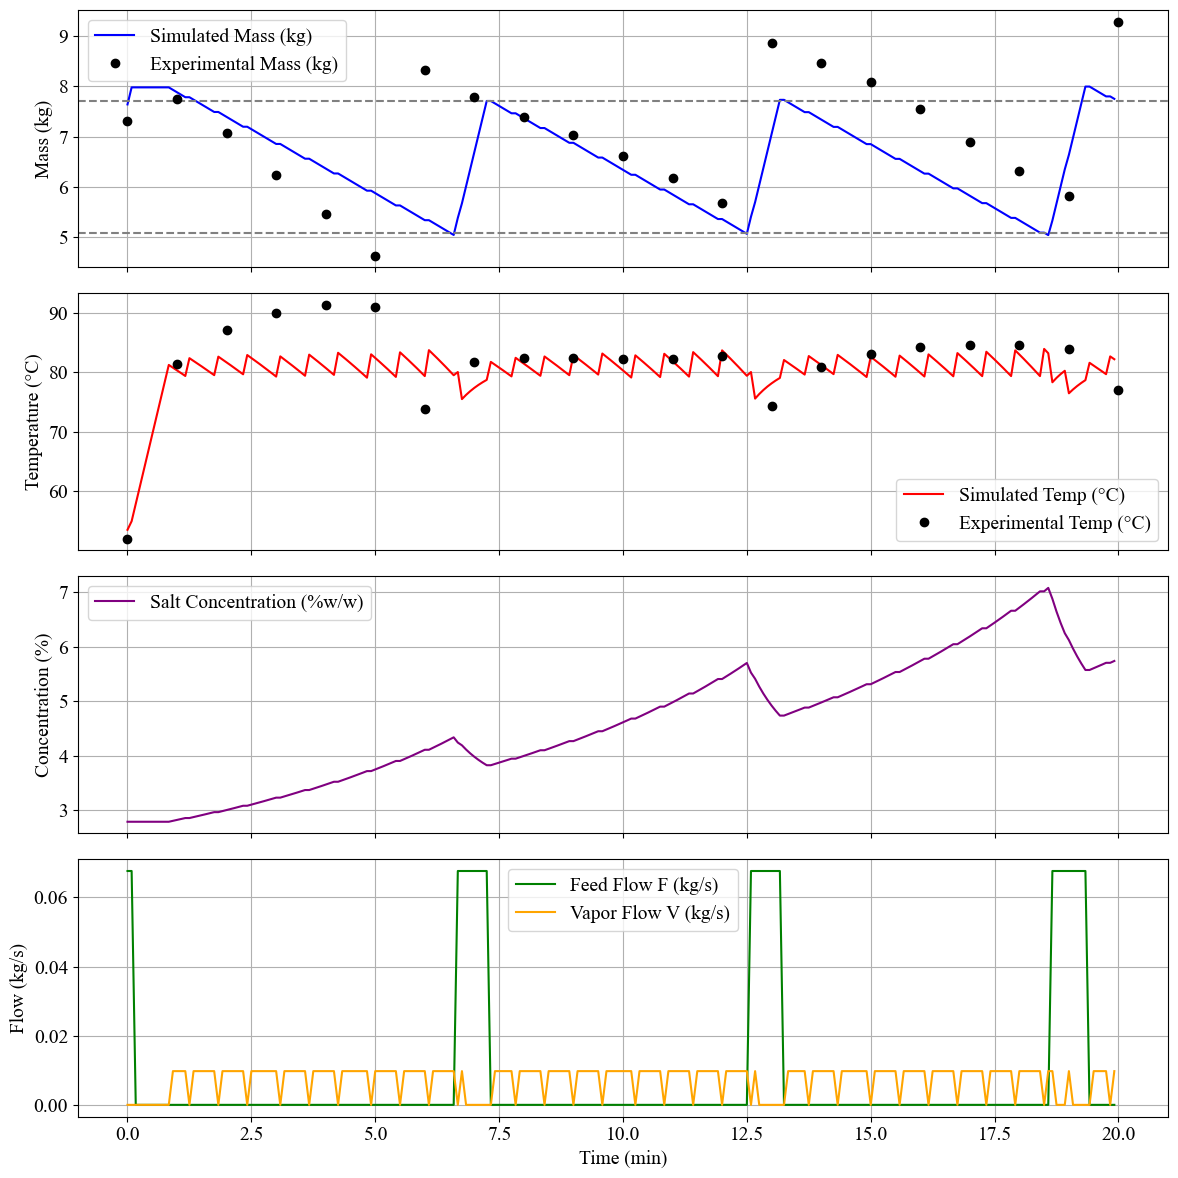

In [ ]:
time_array = np.array(results["time"]) / 60
M_array = np.array(results["mass"])
T_array = np.array(results["temperature_C"])
conc_array = np.array(results["concentration_pct"])
F_array = np.array(results["feed_flow"])
V_array = np.array(results["vapor_flow"]) 
T_eb=results["T_eb"] - 273.15
M_max = 7.7              # Maximum evaporator mass (kg)
M_min = 5.09               # Minimum evaporator mass (kg)
mpl.rcParams['font.family'] = 'Times New Roman'     
mpl.rcParams['font.size'] = 14  # Increase font size      
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

            # Mass plot
axs[0].plot(time_array, M_array, label='Simulated Mass (kg)', color='blue')
axs[0].axhline(M_max, color='gray', linestyle='--')
axs[0].axhline(M_min, color='gray', linestyle='--')
axs[0].plot(t_exp / 60, M_exp, 'o',label='Experimental Mass (kg)', color='black')
axs[0].set_ylabel('Mass (kg)')
axs[0].legend()
axs[0].grid()

            # Temperature plot
axs[1].plot(time_array, T_array, label='Simulated Temp (°C)', color='red')
axs[1].plot(t_exp / 60, T_exp, 'o',label='Experimental Temp (°C)', color='black')

axs[1].set_ylabel('Temperature (°C)')
axs[1].legend()

axs[1].grid()

            # Concentration plot
axs[2].plot(time_array, conc_array, label='Salt Concentration (%w/w)', color='purple')
axs[2].set_ylabel('Concentration (%)')
axs[2].legend()
axs[2].grid()

            # Flow plot
axs[3].plot(time_array, F_array, label='Feed Flow F (kg/s)', color='green')
axs[3].plot(time_array, V_array, label='Vapor Flow V (kg/s)', color='orange')
axs[3].set_xlabel('Time (min)')
axs[3].set_ylabel('Flow (kg/s)')
axs[3].legend()
axs[3].grid()
plt.tight_layout()
plt.show()


In [ ]:
len(results["temperature_C"])
temperatures=results["temperature_C"][12:]
prome=sum(temperatures) / len(temperatures)
prome

80.86625295317093

In [ ]:
# Convertir tiempos experimentales a minutos
t_exp_min = t_exp / 60
Vexp=[0,0.54,1.2,2.04,2.82,3.64,4.02,4.56,4.96,5.3,5.72,6.16,6.66,6.92,7.32,7.7,8.24,8.88,9.46,9.96,10.24]
# Datos predichos desde tu diccionario de resultados
time_array = np.array(results["time"]) / 60  # en minutos
T_array = np.array(results["temperature_C"])
M_array = np.array(results["mass"])

# Encontrar coincidencias exactas de tiempo
mask = np.isin(time_array, t_exp_min)

# Extraer datos predichos en esos tiempos
T_pred_match = T_array[mask]
M_pred_match = M_array[mask]
time_matched = time_array[mask]

# Crear diccionarios para acceder rápido por tiempo
T_pred_dict = dict(zip(time_matched, T_pred_match))
M_pred_dict = dict(zip(time_matched, M_pred_match))

# Obtener los valores predichos y experimentales en orden coincidente
T_pred = np.array([T_pred_dict[t] for t in t_exp_min if t in T_pred_dict])
M_pred = np.array([M_pred_dict[t] for t in t_exp_min if t in M_pred_dict])
T_exp_filtered = np.array([T_exp[i] for i, t in enumerate(t_exp_min) if t in T_pred_dict])
M_exp_filtered = np.array([M_exp[i] for i, t in enumerate(t_exp_min) if t in M_pred_dict])

# Función de error relativo cuadrático medio
def relative_rmse(y_real, y_pred):
    return np.sqrt(np.mean(((y_real - y_pred) / y_real) ** 2))

# Calcular errores
error_T = relative_rmse(T_exp_filtered, T_pred)
error_M = relative_rmse(M_exp_filtered, M_pred)

# Mostrar resultados
print(f"Error relativo cuadrático medio (Temperatura): {error_T:.4f}")
print(f"Error relativo cuadrático medio (Masa): {error_M:.4f}")

Error relativo cuadrático medio (Temperatura): 0.0573
Error relativo cuadrático medio (Masa): 0.1493


In [ ]:
T_pred


array([53.49267073, 80.34988343, 81.69887371, 79.30619579, 80.76430742,
       82.44840275, 79.38832038, 77.4027988 , 81.48392062, 82.93406642,
       80.3453863 , 81.90773751, 83.72463329, 78.16972955, 81.27000538,
       82.64129143, 79.93039363, 81.36932334, 83.03325279, 76.49023928])

In [ ]:
T_exp_filtered

array([52. , 81.5, 87.1, 90. , 91.4, 91.1, 73.9, 81.7, 82.4, 82.5, 82.3,
       82.3, 82.8, 74.4, 80.9, 83.1, 84.3, 84.7, 84.6, 83.9])

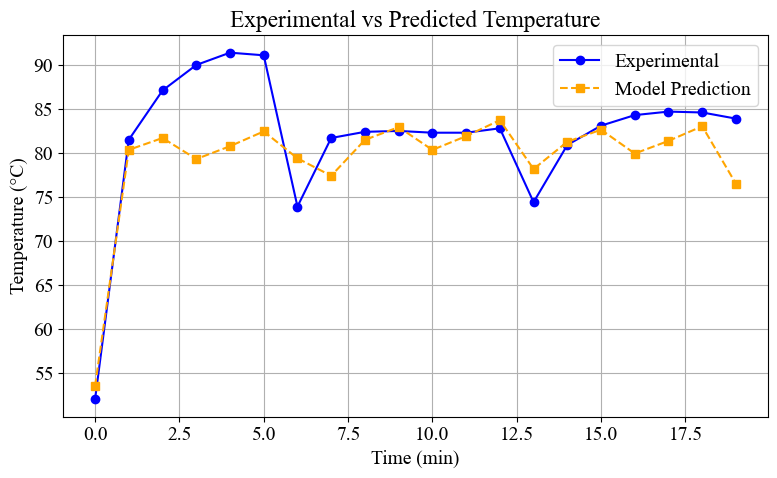

In [ ]:
# Tiempo filtrado, mismo para ambas series
t_matched = np.array([t for t in t_exp_min if t in T_pred_dict])

plt.figure(figsize=(8, 5))
plt.plot(t_matched, T_exp_filtered, 'o-', label='Experimental', color='blue')
plt.plot(t_matched, T_pred, 's--', label='Model Prediction', color='orange')

plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Experimental vs Predicted Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
T_array

array([53.49267073, 54.93707716, 57.86285483, 60.78863251, 63.71441019,
       66.64018787, 69.56596554, 72.49174322, 75.4175209 , 78.34329858,
       81.26907625, 80.81229642, 80.34988343, 79.8817337 , 79.40774109,
       82.40690946, 81.94515711, 81.47756333, 81.00401796, 80.52440806,
       80.03861782, 79.5465285 , 82.66295635, 82.18406384, 81.69887371,
       81.2072625 , 80.70910354, 80.20426681, 79.69261887, 82.93584835,
       82.43847006, 81.93428197, 81.42314513, 80.90491679, 80.37945029,
       79.84659492, 79.30619579, 82.71105204, 82.18629468, 81.65399269,
       81.11398442, 80.56610357, 80.01017909, 79.44603492, 83.0028223 ,
       82.45571075, 81.90037805, 81.33664014, 80.76430742, 80.1831846 ,
       79.59307046, 83.31598115, 82.7444838 , 82.16399283, 81.57429737,
       80.97517995, 80.36641624, 79.74777477, 79.11901664, 83.05648109,
       82.44840275, 81.83020023, 81.2016224 , 80.56240981, 79.91229434,
       79.25099883, 83.39307216, 82.75458863, 82.10491495, 81.44